InSAR Coherence generation with MintPy

In [59]:
## RANDOM TEST TO CHECK ISCE INSTALLATION ##
#import sys
#import os

## Check if isce is importable
#import isce

#print(f"ISCE found at: {isce.__file__}")

# Check if command line tools are found
#!which topsApp.py

Imports and setup

In [60]:
import os
import sys
import isce
import shutil

# --- CONFIGURATION ---
PROJECT_DIR = "/home/st-juho/code_testing"
os.chdir(PROJECT_DIR)

# 1. Find ISCE installation path dynamically
isce_home = os.path.dirname(isce.__file__)

# 2. Locate topsApp.py
# Check standard location in env39
TOPSAPP = os.path.join(isce_home, 'applications', 'topsApp.py')

if not os.path.exists(TOPSAPP):
    # Fallback: Check conda bin
    TOPSAPP = os.path.join(os.path.dirname(sys.executable), 'topsApp.py')

print(f"Current Working Directory: {os.getcwd()}")
print(f"Python Executable: {sys.executable}")

if os.path.exists(TOPSAPP):
    print(f"✅ Found topsApp.py at: {TOPSAPP}")
else:
    print("❌ CRITICAL: Could not find topsApp.py. Is 'env39' active?")

Current Working Directory: /home/st-juho/code_testing
Python Executable: /home/st-juho/code_testing/miniconda3/envs/env39/bin/python
✅ Found topsApp.py at: /home/st-juho/code_testing/miniconda3/envs/env39/lib/python3.9/site-packages/isce/applications/topsApp.py


Define Sentinel-1 SAR inputs

In [61]:
# --- INPUTS ---
# The July 2017 scene (New Download) -> Master (Reference)
master_path = "/home/st-juho/code_testing/S1B_IW_SLC__1SDV_20170725T122204_20170725T122234_006644_00BAFB_0D34.SAFE"

# The August 2017 scene (Previous Slave) -> Slave (Secondary)
slave_path  = "/home/st-juho/code_testing/S1B_IW_SLC__1SDV_20170830T122203_20170830T122233_007169_00CA2C_C92C.SAFE"

# Check if they exist
if not os.path.isdir(master_path):
    raise FileNotFoundError(f"❌ Master not found: {master_path}")
if not os.path.isdir(slave_path):
    raise FileNotFoundError(f"❌ Slave not found: {slave_path}")

print(f"Reference (Master): {os.path.basename(master_path)}")
print(f"Secondary (Slave):  {os.path.basename(slave_path)}")

Reference (Master): S1B_IW_SLC__1SDV_20170725T122204_20170725T122234_006644_00BAFB_0D34.SAFE
Secondary (Slave):  S1B_IW_SLC__1SDV_20170830T122203_20170830T122233_007169_00CA2C_C92C.SAFE


Geometry check

In [62]:
def get_metadata(safe_path):
    manifest = os.path.join(safe_path, "manifest.safe")
    direction = "Unknown"
    track = "Unknown"
    with open(manifest, 'r') as f:
        for line in f:
            # Look for Pass Direction
            if "pass" in line.lower() and "sc:value" not in line:
                if "Ascending" in line: direction = "ASCENDING"
                if "Descending" in line: direction = "DESCENDING"
            # Look for Relative Orbit (Track)
            if "relativeOrbitNumber" in line:
                try:
                    track = line.split('>')[1].split('<')[0]
                except: pass
    return direction, track

m_dir, m_track = get_metadata(master_path)
s_dir, s_track = get_metadata(slave_path)

print(f"Master: {m_dir} (Track {m_track})")
print(f"Slave:  {s_dir} (Track {s_track})")

if m_dir != s_dir:
    raise ValueError("❌ STOP: Pass directions do not match! You cannot interfere Ascending with Descending.")
if m_track != s_track:
    print("⚠️ WARNING: Tracks do not match. If they are adjacent, this might fail. Ideally tracks should match.")
else:
    print("✅ GEOMETRY MATCH: Safe to proceed.")

Master: Unknown (Track 143)
Slave:  Unknown (Track 143)
✅ GEOMETRY MATCH: Safe to proceed.


Config file for ISCE2

Get orbit files

In [63]:
import os
import requests
import netrc

# --- CONFIGURATION ---
# The exact files ISCE requested (from your logs)
files_to_download = [
    "S1B_OPER_AUX_POEORB_OPOD_20170814T111246_V20170724T225942_20170726T005942.EOF",
    "S1B_OPER_AUX_POEORB_OPOD_20170919T111338_V20170829T225942_20170831T005942.EOF"
]

# Define path
orbit_dir = os.path.join(PROJECT_DIR, 'orbits')
if not os.path.exists(orbit_dir):
    os.makedirs(orbit_dir)

# --- 1. GET CREDENTIALS FROM .NETRC ---
try:
    # This reads ~/.netrc
    secrets = netrc.netrc()
    # Look for the Earthdata login
    auth_tuple = secrets.authenticators("urs.earthdata.nasa.gov")
    if not auth_tuple:
        # Fallback to generic if specific host not found
        auth_tuple = secrets.authenticators("earthdata.nasa.gov")
    
    if auth_tuple:
        username, _, password = auth_tuple
        print(f"✅ Found credentials for user: {username}")
    else:
        raise ValueError("No credentials found in ~/.netrc for earthdata!")
        
except Exception as e:
    print(f"❌ .netrc Error: {e}")
    print("Please ensure ~/.netrc exists and has permissions 600.")
    # Stop here if no auth
    username = None
    password = None

# --- 2. DOWNLOAD LOOP ---
if username:
    # We use a session to handle cookies/redirects
    session = requests.Session()
    session.auth = (username, password)
    
    for filename in files_to_download:
        url = f"https://s1qc.asf.alaska.edu/aux_poeorb/{filename}"
        dest_path = os.path.join(orbit_dir, filename)
        
        print(f"\n⬇️ Attempting download: {filename}")
        
        try:
            response = session.get(url, stream=True)
            
            if response.status_code == 200:
                # Check if it's actually XML and not an HTML error page
                content_type = response.headers.get('content-type', '')
                
                if "text/html" in content_type:
                     print("❌ Error: Server returned HTML (Login Page) instead of XML file.")
                else:
                    with open(dest_path, 'wb') as f:
                        for chunk in response.iter_content(chunk_size=8192):
                            f.write(chunk)
                    print("✅ Download Success!")
                    
                    # Verify XML Header
                    with open(dest_path, 'r') as f:
                        head = f.readline()
                    if "xml" in head.lower():
                        print("   (Verified valid XML structure)")
                    else:
                        print("   ⚠️ Warning: File header does not look like XML.")
            
            elif response.status_code == 404:
                print("❌ Error 404: File not found on ASF server.")
            elif response.status_code == 401:
                print("❌ Error 401: Unauthorized. Check your username/password.")
            else:
                print(f"❌ Failed with status code: {response.status_code}")
                
        except Exception as e:
            print(f"❌ Connection Error: {e}")

✅ Found credentials for user: juhoarjanne

⬇️ Attempting download: S1B_OPER_AUX_POEORB_OPOD_20170814T111246_V20170724T225942_20170726T005942.EOF
2025-12-01 19:01:28,068 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s1qc.asf.alaska.edu:443
2025-12-01 19:01:28,674 - urllib3.connectionpool - DEBUG - https://s1qc.asf.alaska.edu:443 "GET /aux_poeorb/S1B_OPER_AUX_POEORB_OPOD_20170814T111246_V20170724T225942_20170726T005942.EOF HTTP/1.1" 302 145
2025-12-01 19:01:28,682 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): urs.earthdata.nasa.gov:443
2025-12-01 19:01:29,442 - urllib3.connectionpool - DEBUG - https://urs.earthdata.nasa.gov:443 "GET /oauth/authorize?response_type=code&client_id=BO_n7nTIlMljdvU6kRRB3g&redirect_uri=https://auth.asf.alaska.edu/login&state=https://s1qc.asf.alaska.edu/aux_poeorb/S1B_OPER_AUX_POEORB_OPOD_20170814T111246_V20170724T225942_20170726T005942.EOF&app_type=401 HTTP/1.1" 302 None
2025-12-01 19:01:29,453 - urllib3.connecti

ISCE2 Processing:

In [64]:
import shutil
import subprocess
import os
import sys

# --- 1. HARD RESET (REQUIRED) ---
# We must delete old folders so ISCE doesn't reuse the full-scene data
folders_to_wipe = ['reference', 'secondary', 'merged', 'pickle', 'fine_interferogram', 'geom_reference']
for folder in folders_to_wipe:
    if os.path.exists(folder):
        print(f"🗑️ Deleting old data: {folder}/")
        shutil.rmtree(folder)
if os.path.exists("topsApp.xml"):
    os.remove("topsApp.xml")

# --- 2. CONFIGURE WITH ROI ---
# East Houston ROI [South, North, West, East]
# Corrected order: LatMin, LatMax, LonMin, LonMax
roi = [29.786186, 29.873121, -95.708479, -95.573593]

# Create a directory for DEMs
dem_dir = os.path.join(PROJECT_DIR, 'dem_files')
if not os.path.exists(dem_dir):
    os.makedirs(dem_dir)

topsApp_xml = f"""<?xml version="1.0" encoding="UTF-8"?>
<topsApp>
  <component name="topsinsar">
    <component name="reference">
      <property name="orbit directory">{os.path.join(PROJECT_DIR, 'orbits')}</property>
      <property name="auxiliary data directory">{os.path.join(PROJECT_DIR, 'aux')}</property>
      <property name="output directory">reference</property>
      <property name="safe">['{master_path}']</property>
    </component>
    <component name="secondary">
      <property name="orbit directory">{os.path.join(PROJECT_DIR, 'orbits')}</property>
      <property name="auxiliary data directory">{os.path.join(PROJECT_DIR, 'aux')}</property>
      <property name="output directory">secondary</property>
      <property name="safe">['{slave_path}']</property>
    </component>
    
    <!-- Process all swaths, ISCE will pick the one covering the ROI -->
    <property name="swaths">[1, 2, 3]</property>
    <property name="range looks">7</property>
    <property name="azimuth looks">3</property>
    <property name="do unwrap">False</property>
    
    <!-- THIS FORCES SUBSETTING -->
    <property name="region of interest">{roi}</property>

    <!-- Save DEM to a specific folder -->
    <property name="demFilename">{os.path.join(dem_dir, 'dem.wgs84')}</property>
    
  </component>
</topsApp>
"""


In [65]:
# --- MANUAL DEM DOWNLOAD (Copernicus 30m) ---
# topsApp.py sometimes fails to download the DEM automatically.
# We will use a custom script to download Copernicus 30m DEM tiles, 
# convert them to HGT format, and then use dem.py to stitch.

import math
import requests
import zipfile
import glob
import shutil
import subprocess
import xml.etree.ElementTree as ET

# Ensure dem_dir exists
if not os.path.exists(dem_dir):
    os.makedirs(dem_dir)

# Clean up old DEM files to avoid confusion
print("Cleaning up old DEM files...")
for f in glob.glob(os.path.join(dem_dir, "dem*")):
    # Be careful not to delete the directory itself
    if os.path.isfile(f):
        os.remove(f)

# Calculate integer bounds for dem.py (S N W E)
dem_s = int(math.floor(roi[0]))
dem_n = int(math.ceil(roi[1]))
dem_w = int(math.floor(roi[2]))
dem_e = int(math.ceil(roi[3]))

print(f"DEM Bounding Box: South={dem_s}, North={dem_n}, West={dem_w}, East={dem_e}")

# Identify required tiles
# Copernicus tiles are 1x1 degree, similar to SRTM but different naming.
tiles = []
for lat in range(dem_s, dem_n):
    for lon in range(dem_w, dem_e):
        # Format: NxxWyyy for HGT
        ns = 'N' if lat >= 0 else 'S'
        ew = 'E' if lon >= 0 else 'W'
        lat_str = f"{abs(lat):02d}"
        lon_str = f"{abs(lon):03d}"
        
        # Copernicus Naming: Copernicus_DSM_COG_10_N29_00_W096_00_DEM
        cop_name = f"Copernicus_DSM_COG_10_{ns}{lat_str}_00_{ew}{lon_str}_00_DEM"
        
        # HGT Naming for dem.py
        hgt_name = f"{ns}{lat_str}{ew}{lon_str}.hgt"
        
        tiles.append((lat, lon, cop_name, hgt_name))

print(f"Required tiles: {[t[3] for t in tiles]}")

# Download tiles from AWS Open Data
base_url = "https://copernicus-dem-30m.s3.amazonaws.com/"

# Setup session
session = requests.Session()
# No auth needed for public bucket

for lat, lon, cop_name, hgt_name in tiles:
    # Copernicus URL structure
    # https://copernicus-dem-30m.s3.amazonaws.com/Copernicus_DSM_COG_10_N29_00_W096_00_DEM/Copernicus_DSM_COG_10_N29_00_W096_00_DEM.tif
    url = f"{base_url}{cop_name}/{cop_name}.tif"
    
    tif_path = os.path.join(dem_dir, f"{cop_name}.tif")
    hgt_path = os.path.join(dem_dir, hgt_name)
    
    # 1. Download GeoTIFF
    if not os.path.exists(tif_path) and not os.path.exists(hgt_path):
        print(f"⬇️ Downloading {cop_name}.tif...")
        try:
            response = session.get(url, stream=True)
            if response.status_code == 200:
                with open(tif_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
                print(f"✅ Downloaded {cop_name}.tif")
            elif response.status_code == 404:
                print(f"❌ Error 404: Tile not found: {url}")
            else:
                print(f"❌ Failed to download: {response.status_code}")
        except Exception as e:
            print(f"❌ Exception downloading {cop_name}: {e}")
    
    # 2. Convert to HGT using gdal_translate
    if os.path.exists(tif_path) and not os.path.exists(hgt_path):
        print(f"🔄 Converting {cop_name}.tif to {hgt_name}...")
        try:
            # Use gdal_translate to convert to SRTMHGT format
            # -of SRTMHGT
            cmd_conv = ["gdal_translate", "-q", "-of", "SRTMHGT", tif_path, hgt_path]
            subprocess.check_call(cmd_conv)
            print(f"✅ Converted to {hgt_name}")
            
            # Optional: Remove the tif to save space
            # os.remove(tif_path)
        except subprocess.CalledProcessError as e:
            print(f"❌ Conversion failed: {e}")
        except FileNotFoundError:
            print("❌ gdal_translate not found. Is GDAL installed?")

# Now run dem.py to stitch/process
dem_script = os.path.join(isce_home, 'applications', 'dem.py')

# Use a simple prefix, dem.py will likely append .wgs84
dem_prefix = "dem" 

# -l: local files
# -k: keep files
# -s 1: SRTM1 (1 arcsec) - appropriate for 30m Copernicus
cmd_dem = [
    sys.executable, dem_script,
    "-a", "stitch",
    "-b", str(dem_s), str(dem_n), str(dem_w), str(dem_e),
    "-r",
    "-s", "1",
    "-c",
    "-d", dem_dir,
    "-o", dem_prefix,
    "-l", # Use local files
    "-k"  # Keep files
]

print(f"Running DEM stitching: {' '.join(cmd_dem)}")

try:
    subprocess.check_call(cmd_dem)
    print("✅ DEM generated successfully.")
    
    # Identify what was generated
    # dem.py usually generates {prefix}.wgs84
    generated_base = f"{dem_prefix}.wgs84"
    
    # Move generated files to dem_dir
    # This catches dem.wgs84, dem.wgs84.xml, dem.wgs84.vrt, etc.
    moved_files = []
    for f in glob.glob(f"{generated_base}*"):
        src = os.path.join(os.getcwd(), f)
        dst = os.path.join(dem_dir, f)
        
        # Avoid moving if it's already there
        if os.path.abspath(src) == os.path.abspath(dst):
            continue
            
        if os.path.exists(dst):
            os.remove(dst)
        
        shutil.move(src, dst)
        moved_files.append(dst)
        print(f"   Moved {f} -> {dem_dir}/")
    
    if not moved_files:
        print("⚠️ Warning: No files moved. Did dem.py generate files with expected name?")
        print(f"Looking for {generated_base}* in {os.getcwd()}")
        print(f"Files in CWD: {glob.glob('dem*')}")
        
    # --- FIX XML PATHS ---
    # ISCE XML files contain absolute paths to the binary files.
    # Since we moved the files, we must update the XMLs.
    print("Fixing XML paths...")
    for xml_file in glob.glob(os.path.join(dem_dir, "*.xml")):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            changed = False
            
            for prop in root.findall(".//property"):
                name = prop.get('name')
                if name in ['file_name', 'extra_file_name', 'metadata_location']:
                    val_elem = prop.find('value')
                    if val_elem is not None:
                        old_path = val_elem.text
                        basename = os.path.basename(old_path)
                        new_path = os.path.join(dem_dir, basename)
                        
                        if old_path != new_path:
                            val_elem.text = new_path
                            changed = True
                            print(f"   Updated {name}: {basename} -> {new_path}")
            
            if changed:
                tree.write(xml_file)
                print(f"   Saved updates to {os.path.basename(xml_file)}")
                
        except Exception as e:
            print(f"   ❌ Failed to fix XML {xml_file}: {e}")

    # --- UPDATE topsApp.xml ---
    # We assume the main file is dem.wgs84
    final_dem_path = os.path.join(dem_dir, generated_base)
    print(f"Final DEM Path: {final_dem_path}")
    
    # Parse topsApp_xml string to update it robustly
    try:
        root = ET.fromstring(topsApp_xml)
        # Find the demFilename property
        # It's under component[name=topsinsar] -> component[name=reference] ? No, it's under topsinsar directly in my template
        # Let's search recursively
        for prop in root.findall(".//property"):
            if prop.get('name') == 'demFilename':
                prop.text = final_dem_path
                print(f"   Updated topsApp.xml demFilename to: {final_dem_path}")
                break
        
        # Convert back to string
        topsApp_xml = ET.tostring(root, encoding='unicode')
        
    except Exception as e:
        print(f"❌ Failed to update topsApp_xml string: {e}")
        # Fallback to string replace
        topsApp_xml = topsApp_xml.replace(
            f"<property name=\"demFilename\">{os.path.join(dem_dir, 'dem.wgs84')}</property>",
            f"<property name=\"demFilename\">{final_dem_path}</property>"
        )

except subprocess.CalledProcessError as e:
    print(f"❌ DEM generation failed: {e}")

Cleaning up old DEM files...
DEM Bounding Box: South=29, North=30, West=-96, East=-95
Required tiles: ['N29W096.hgt']
Running DEM stitching: /home/st-juho/code_testing/miniconda3/envs/env39/bin/python /home/st-juho/code_testing/miniconda3/envs/env39/lib/python3.9/site-packages/isce/applications/dem.py -a stitch -b 29 30 -96 -95 -r -s 1 -c -d /home/st-juho/code_testing/dem_files -o dem -l -k
API open (R): /home/st-juho/code_testing/dem_files/dem
API close:  /home/st-juho/code_testing/dem_files/dem
Writing geotrans to VRT for /home/st-juho/code_testing/dem_files/dem
GDAL open (R): /home/st-juho/code_testing/dem_files/dem.vrt
API open (WR): dem.wgs84

    << Geoid Correction I2 SRTM>>

Jet Propulsion Laboratory - Radar Science and Engineering


Sampling Geoid at grid points -  Longitude Samples:    13 Latitude Lines:    13
Corner Geoid Heights (m) =  -27.30 -28.35 -28.60 -28.57

Correcting data to geoid height...

At line:      512
At line:     1024
At line:     1536
At line:     2048
At 

In [66]:

with open("topsApp.xml", "w") as f:
    f.write(topsApp_xml)
print(f"✅ Configuration reset. ROI set to: {roi}")

# --- 3. RUN PROCESSING ---
# Clean env
my_env = os.environ.copy()
keys_to_kill = ['PYTHONPATH', 'ISCE_HOME', 'ISCE_ROOT']
for key in keys_to_kill:
    if key in my_env: del my_env[key]
current_site_packages = os.path.join(os.path.dirname(os.path.dirname(sys.executable)), 'lib', 'python3.9', 'site-packages')
my_env['PYTHONPATH'] = current_site_packages

command = f"{sys.executable} {TOPSAPP} topsApp.xml --start=startup --end=geocode"

print(f"🚀 Starting Fresh Processing (Subset)...")
# Redirect output to a log file
with open("isce_run.log", "w") as log_file:
    process = subprocess.Popen(command, shell=True, stdout=log_file, stderr=subprocess.STDOUT, text=True, env=my_env)
    process.wait()

print(f"Processing finished with return code: {process.returncode}")

if process.returncode == 0:
    print("\n✅ Success! Processing finished on subset.")
else:
    print("\n❌ Failed. Check isce_run.log for details.")
    # Print the last 20 lines of the log
    print("--- Last 20 lines of log ---")
    with open("isce_run.log", "r") as f:
        lines = f.readlines()
        for line in lines[-20:]:
            print(line.strip())


✅ Configuration reset. ROI set to: [29.786186, 29.873121, -95.708479, -95.573593]
🚀 Starting Fresh Processing (Subset)...
Processing finished with return code: 0

✅ Success! Processing finished on subset.


Visualize

Generating Map...
Running: view.py /home/st-juho/code_testing/merged/topophase.cor.geo --sub-lat 29.786186 29.873121 --sub-lon -95.708479 -95.573593 -c gray -v 0 1 --nodisplay -o coherence.png --title 'Coherence Map (East Houston)'
run view.py in MintPy version 1.6.2, date 2025-07-07
input file is isce .cor file: /home/st-juho/code_testing/merged/topophase.cor.geo in float32 format
file size in y/x: (2743, 7219)
num of datasets in file topophase.cor.geo: 2
datasets to exclude (0):
[]
datasets to display (2):
['band1', 'band2']
data   coverage in y/x: (0, 0, 7219, 2743)
subset coverage in y/x: (3416, 1243, 3902, 1556)
data   coverage in lat/lon: (-96.65763888888888, 30.21847222222222, -94.6523611111111, 29.456527777777776)
subset coverage in lat/lon: (-95.70875, 29.873194444444444, -95.57374999999999, 29.78625)
------------------------------------------------------------------------
colormap: gray
figure title: Coherence Map (East Houston)
figure size : [15.00, 8.00]
dataset number: 2
r

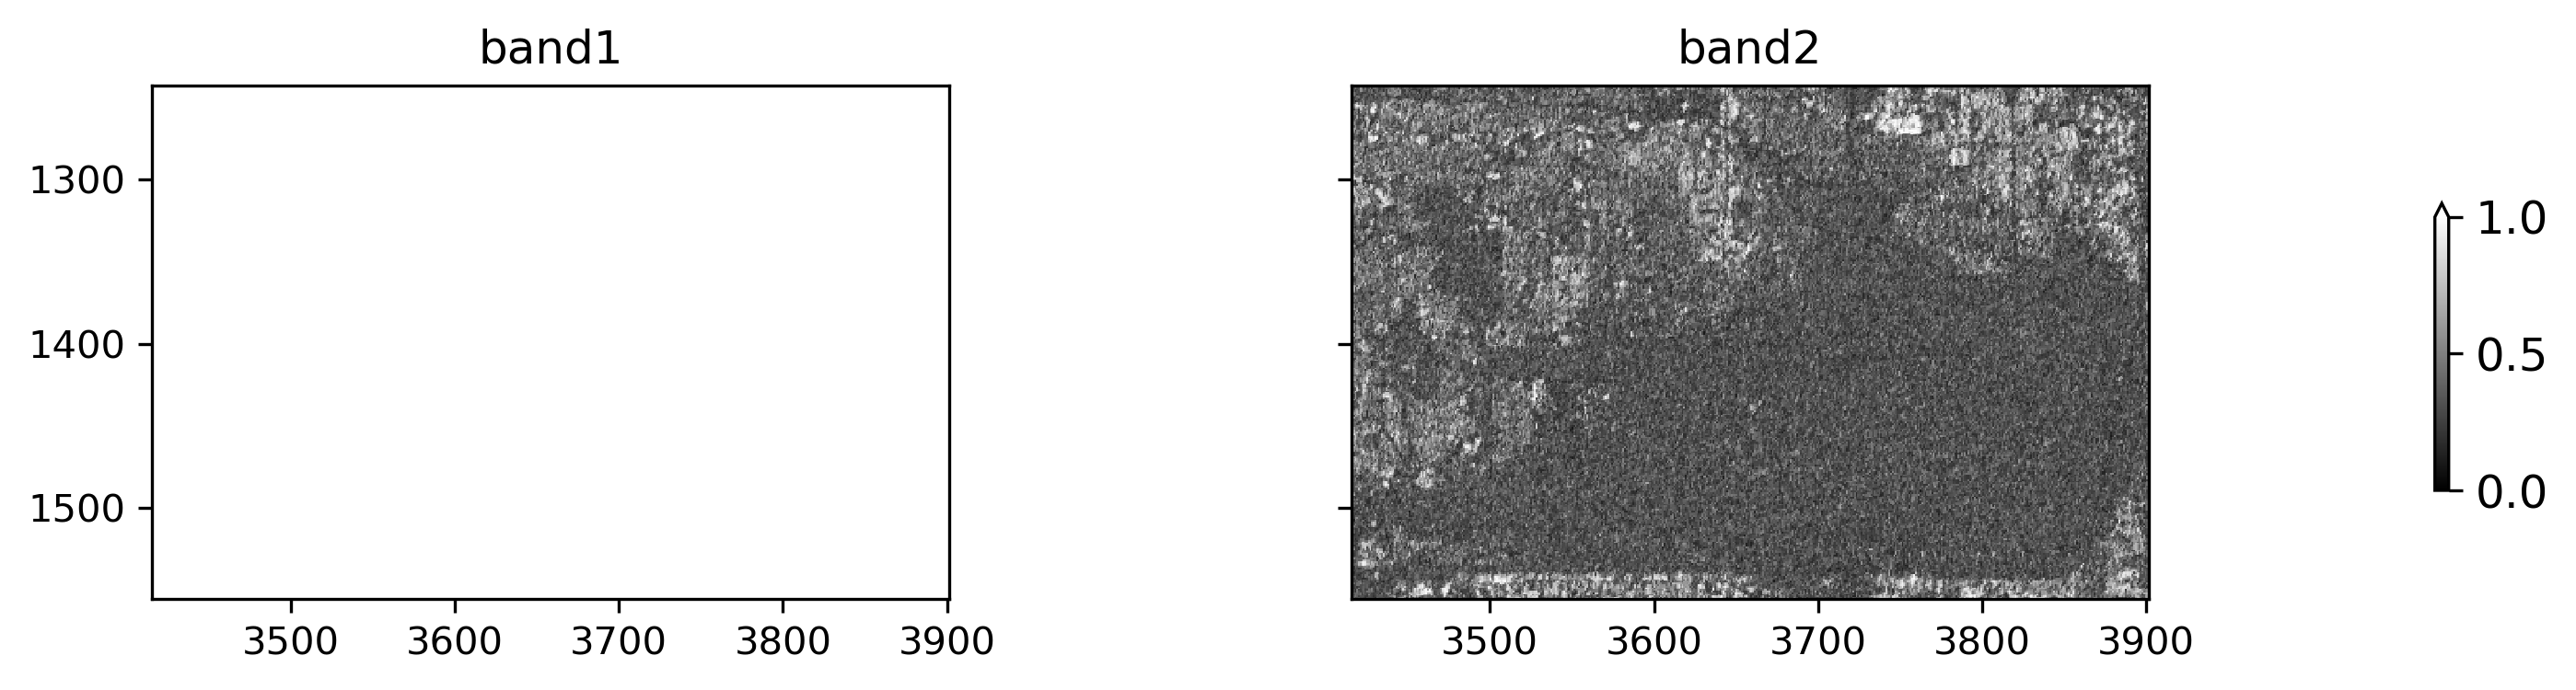

In [67]:
from mintpy.cli import view
from IPython.display import Image, display

# The output file from ISCE
geo_cor_file = os.path.join(PROJECT_DIR, "merged", "topophase.cor.geo")

if os.path.exists(geo_cor_file):
    print("Generating Map...")
    
    # Explicitly define the bounds for East Houston to avoid variable mix-ups
    # Order: South, North, West, East
    lat_min = 29.786186
    lat_max = 29.873121
    lon_min = -95.708479
    lon_max = -95.573593
    
    # Use --sub-lat (South North) and --sub-lon (West East)
    cmd = (f"{geo_cor_file} "
           f"--sub-lat {lat_min} {lat_max} --sub-lon {lon_min} {lon_max} "
           f"-c gray -v 0 1 --nodisplay -o coherence.png --title 'Coherence Map (East Houston)'")
    
    print(f"Running: view.py {cmd}")
    !view.py {cmd}
    
    # Show Image
    if os.path.exists("coherence.png"):
        display(Image(filename='coherence.png'))
    else:
        print("❌ Error: coherence.png was not created.")
else:
    print("❌ Output file# filepath: /home/st-juho/code_testing/insar_coherence.ipynb")
